# $D^0 \to K^0_Sπ^+π^-$ with Mixing

We will fit 

$$
D^0 \to K^0_S \pi^+\pi^-
$$

decays generated with the following intermediate resonances:
- $D^0 \to K^0_S \rho(770)$
- $D^0 \to K^{*-}\pi^+$

In addition we add mixing, meaning that $D^0$ oscillates to $\bar{D}^0$, which subsequently decays with a charged-conjugate decay model, depending on time:

$$
|\mathcal{A}(t)|^2 = \frac{1}{4}\left|\mathcal{A}_{D^0} + \frac{q}{p}\mathcal{A}_{\bar{D}^0}\right|^2 \psi_+(t) + 
                     \frac{1}{4}\left|\mathcal{A}_{D^0} - \frac{q}{p}\mathcal{A}_{\bar{D}^0}\right|^2 \psi_-(t) + 
                     2 \Re{\left((\mathcal{A}_{D^0} + \frac{q}{p}\mathcal{A}_{\bar{D}^0})(\mathcal{A}_{D^0} - \frac{q}{p}\mathcal{A}_{\bar{D}^0})^*\psi_i(t)\right)},
$$

with

$$
\begin{align*}
\psi_+(t) &= e^{ -(1+y)\frac{t}{\tau} }\\
\psi_-(t) &= e^{ -(1-y)\frac{t}{\tau} }\\
\psi_i(t) &= e^{ -(1+ix)\frac{t}{\tau} }\\
\end{align*}
$$

Import modules

In [1]:
# import NumPy
import numpy as np
# Import Tensorflow
import tensorflow as tf
# Import AmpliTF modules
import amplitf.interface as atfi
import amplitf.kinematics as atfk
import amplitf.dynamics as atfd
import amplitf.likelihood as atfl
import amplitf.mixing as atfm
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace
from amplitf.phasespace.decaytime_phasespace import DecayTimePhaseSpace
from amplitf.phasespace.combined_phasespace import CombinedPhaseSpace
#from amplitf.mixing import psip, psim, psii, mixing_density

# Import TFA modules
import tfa.toymc as tft
import tfa.plotting as tfp
import tfa.optimisation as tfo

# Import plotting module
import matplotlib.pyplot as plt

2025-06-05 15:08:53.858328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749128933.878736  941233 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749128933.884924  941233 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749128933.900973  941233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749128933.900995  941233 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749128933.901002  941233 computation_placer.cc:177] computation placer alr

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


I0000 00:00:1749128936.253227  941233 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46761 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


Set the number of events to generate and the number of normalisation point to calculate the integral of the likelihood

In [67]:
ntoys = 100000  # Number of points to generate
nnorm = 1000000  # Number of normalisation points

Now define the phase space

In [3]:
# Phase space
# Masses of final state particles
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)
tdz = atfi.const(1.)
tphsp = DecayTimePhaseSpace(tdz)
c_phsp = CombinedPhaseSpace(phsp,tphsp)

The mixing parameters

In [4]:
x_mix = atfi.const(0.)#atfi.const(0.004)
y_mix = atfi.const(0.0)#atfi.const(0.0064)
qop_mix = atfi.const(1)
phi_mix = atfi.const(0)
qoverp = atfi.complex( qop_mix * atfi.cos(phi_mix), 
                       qop_mix * atfi.sin(phi_mix) )

## Phasespace
Let's study the phasespace and the value of the functions on it

In [5]:
unfi_sample = c_phsp.unfiltered_sample(10000,1.0e-20)
comb_sample = c_phsp.filter(unfi_sample)

Plot the invariant masses and the decay time

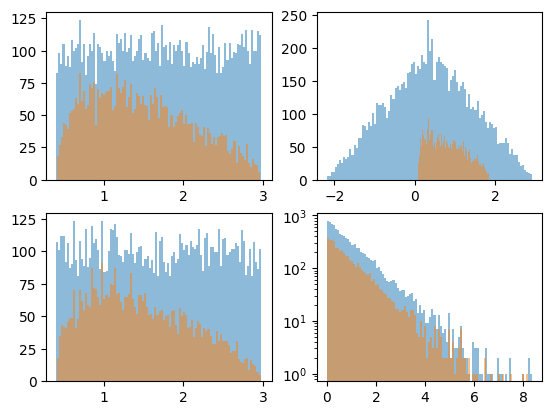

In [6]:
fig, ax = plt.subplots(2,2)
_ = ax[0][0].hist( np.array(c_phsp.phsp1.m2ab(c_phsp.data1(unfi_sample)) ),bins=100, alpha=0.5)
_ = ax[0][0].hist( np.array(c_phsp.phsp1.m2ab(c_phsp.data1(comb_sample)) ),bins=100, alpha=0.5)
_ = ax[1][0].hist( np.array(c_phsp.phsp1.m2bc(c_phsp.data1(unfi_sample)) ),bins=100, alpha=0.5)
_ = ax[1][0].hist( np.array(c_phsp.phsp1.m2bc(c_phsp.data1(comb_sample)) ),bins=100, alpha=0.5)
_ = ax[0][1].hist( np.array(c_phsp.phsp1.m2ac(c_phsp.data1(unfi_sample)) ),bins=100, alpha=0.5)
_ = ax[0][1].hist( np.array(c_phsp.phsp1.m2ac(c_phsp.data1(comb_sample)) ),bins=100, alpha=0.5)
_ = ax[1][1].hist( np.array(c_phsp.phsp2.t(c_phsp.data2(unfi_sample)) ),bins=100, alpha=0.5)
_ = ax[1][1].hist( np.array(c_phsp.phsp2.t(c_phsp.data2(comb_sample)) ),bins=100, alpha=0.5)
ax[1][1].set_yscale('log')

## Model
Below there is a function to define the model, allowing to switch on and off specific components.

In [7]:
from context import models
from models.d02kspipi import babar2008_model_amp
from models.helpers import decode_model, plot_data, plot_data_mix, plot_data_comparison_mix

In [8]:
meta = atfi.const(lp.eta.mass/1000.)
metap = atfi.const(lp.etap_958.mass/1000.)
belle_model = decode_model('../../d02kspipi_toys/generator/inputs/belle_model.txt')

In [9]:
def babar_model_amp(x):
    return babar2008_model_amp(x, phsp,
        atfi.const(belle_model['rho770_Mass'][0]),
        atfi.const(belle_model['rho770_Width'][0]),
        atfi.const(belle_model['Kstar892_Mass'][0]),
        atfi.const(belle_model['Kstar892_Width'][0]),
        atfi.const(belle_model['Kstartwo1430_Mass'][0]),
        atfi.const(belle_model['Kstartwo1430_Width'][0]),
        atfi.const(belle_model['Kstar1410_Mass'][0]),
        atfi.const(belle_model['Kstar1410_Width'][0]),
        atfi.const(belle_model['Kstar1680_Mass'][0]),
        atfi.const(belle_model['Kstar1680_Width'][0]),
        atfi.const(belle_model['omega_Mass'][0]),
        atfi.const(belle_model['omega_Width'][0]),
        atfi.const(belle_model['ftwo1270_Mass'][0]),
        atfi.const(belle_model['ftwo1270_Width'][0]),
        atfi.const(belle_model['rho1450_Mass'][0]),
        atfi.const(belle_model['rho1450_Width'][0]),
        # LASS
        atfi.const(belle_model['LASS_a'][0]),
        atfi.const(belle_model['LASS_r'][0]),
        atfi.const(1.4617),
        atfi.const(0.2683),
        atfi.const(belle_model['LASS_R'][0]),
        atfi.const(belle_model['LASS_phi_R'][0]),
        atfi.const(belle_model['LASS_F'][0]),
        atfi.const(belle_model['LASS_phi_F'][0]),
        # K matrix model parameters
        atfi.const( [0.651, 1.2036, 1.55817, 1.21, 1.82206] ),
        atfi.const( [ [0.22889, -0.55377, 0, -0.39899, -0.34639],
                        [0.94128, 0.55095, 0, 0.39065, 0.31503],
                        [0.36856, 0.23888, 0.55639, 0.18340, 0.18681],
                        [0.33650, 0.40907, 0.85679, 0.19906, -0.00984],
                        [0.18171, -0.17558, -0.79658, -0.00355, 0.22358]] ),
        atfi.const(-3.92637),
        atfi.const([ [  0.23399,  0.15044, -0.20545,  0.32825,  0.35412],
                   [  0.15044, 0, 0, 0, 0],
                   [ -0.20545, 0, 0, 0, 0],
                   [  0.32825, 0, 0, 0, 0],
                   [  0.35412, 0, 0, 0, 0]]),
        atfi.stack([belle_model[f'Kmatrix_beta{i}_realpart'][0]+\
                    1.j*belle_model[f'Kmatrix_beta{i}_imaginarypart'][0] for i in range(1, 6)]),
        atfi.const(-0.070000000000000),
        atfi.stack([belle_model[f'Kmatrix_f_prod_1{i}_realpart'][0]+\
                    1.j*belle_model[f'Kmatrix_f_prod_1{i}_imaginarypart'][0] for i in range(1, 6)]),
        [[mpi,mpi], [mkz, mkz], [mpi], [meta, meta], [meta, metap]])

def Af(x, switches=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]):#15 * [1]):
    return babar_model_amp(x)(
        switches=switches,
        a1r=atfi.const(1.0), 
        a1i=atfi.const(0.0),
        a2r=atfi.const(belle_model['Kstar892minus_realpart'][0]),
        a2i=atfi.const(belle_model['Kstar892minus_imaginarypart'][0]),
        a3r=atfi.const(belle_model['Kstarzero1430minus_realpart'][0]),
        a3i=atfi.const(belle_model['Kstarzero1430minus_imaginarypart'][0]),
        a4r=atfi.const(belle_model['Kstartwo1430minus_realpart'][0]),
        a4i=atfi.const(belle_model['Kstartwo1430minus_imaginarypart'][0]),
        a5r=atfi.const(belle_model['Kstar1410minus_realpart'][0]),
        a5i=atfi.const(belle_model['Kstar1410minus_imaginarypart'][0]),
        a6r=atfi.const(belle_model['Kstar1680minus_realpart'][0]),
        a6i=atfi.const(belle_model['Kstar1680minus_imaginarypart'][0]),
        a7r=atfi.const(belle_model['Kstar892plus_realpart'][0]),
        a7i=atfi.const(belle_model['Kstar892plus_imaginarypart'][0]),
        a8r=atfi.const(belle_model['Kstarzero1430plus_realpart'][0]),
        a8i=atfi.const(belle_model['Kstarzero1430plus_imaginarypart'][0]),
        a9r=atfi.const(belle_model['Kstartwo1430plus_realpart'][0]),
        a9i=atfi.const(belle_model['Kstartwo1430plus_imaginarypart'][0]),
        a10r=atfi.const(belle_model['Kstar1410plus_realpart'][0]),
        a10i=atfi.const(belle_model['Kstar1410plus_imaginarypart'][0]),
        a11r=atfi.const(belle_model['Kstar1680plus_realpart'][0]),
        a11i=atfi.const(belle_model['Kstar1680plus_imaginarypart'][0]),
        a12r=atfi.const(belle_model['omega_realpart'][0]),
        a12i=atfi.const(belle_model['omega_imaginarypart'][0]),
        a13r=atfi.const(belle_model['ftwo1270_realpart'][0]),
        a13i=atfi.const(belle_model['ftwo1270_imaginarypart'][0]),
        a14r=atfi.const(belle_model['rho1450_realpart'][0]),
        a14i=atfi.const(belle_model['rho1450_imaginarypart'][0]),
    )

def Afbar(x):
    # the conjugate of the amplitude
    # is the same as the amplitude with the masses swapped
    return Af(x[:,::-1])

In [10]:
c_phsp.phsp2.t(c_phsp.data2(comb_sample))

<tf.Tensor: shape=(4716,), dtype=float64, numpy=
array([0.46118378, 1.21021764, 2.65858449, ..., 2.74759506, 0.40336028,
       0.71012343])>

In [11]:
def model_mix(x):
    # Calculate the amplitudes
    ampl_dz = Af(c_phsp.data1(x))
    ampl_dzb = Afbar(c_phsp.data1(x))
    def _model(x_mix_par, y_mix_par, qoverp_re, qoverp_im):
        t = c_phsp.phsp2.t(c_phsp.data2(x))
        tep = atfm.psip(t, y_mix_par, atfi.const(1.0))
        tem = atfm.psim(t, y_mix_par, atfi.const(1.0))
        tei = atfm.psii(t, x_mix_par, atfi.const(1.0))
        # calculate the amplitude density
        dens = atfm.mixing_density(ampl_dz, ampl_dzb, atfi.complex(qoverp_re, qoverp_im), tep, tem, tei)
        return dens
    return _model

In [12]:
def toymc_model_mix(x):
    return model_mix(x)(
        x_mix_par=x_mix,
        y_mix_par=y_mix,
        qoverp_re=atfi.real(qoverp),
        qoverp_im=atfi.imaginary(qoverp)
        )

In [13]:
ntoys = 100000
toy_sample = tft.run_toymc(
    toymc_model_mix, c_phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)

I0000 00:00:1749128946.067141  941436 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x562929ea05c0


  Updating maximum: 1e-20 -> 6800.446684031822. Starting over.
  Chunk 1, size=5544, total length=5544
  Chunk 2, size=5374, total length=10918
  Chunk 3, size=5497, total length=16415
  Chunk 4, size=5380, total length=21795
  Chunk 5, size=5532, total length=27327
  Chunk 6, size=5313, total length=32640
  Chunk 7, size=5515, total length=38155
  Chunk 8, size=5569, total length=43724
  Chunk 9, size=5477, total length=49201
  Chunk 10, size=5427, total length=54628
  Chunk 11, size=5435, total length=60063
  Chunk 12, size=5500, total length=65563
  Chunk 13, size=5444, total length=71007
  Chunk 14, size=5440, total length=76447
  Chunk 15, size=5430, total length=81877
  Chunk 16, size=5412, total length=87289
  Chunk 17, size=5561, total length=92850
  Chunk 18, size=5394, total length=98244
  Chunk 19, size=5508, total length=103752


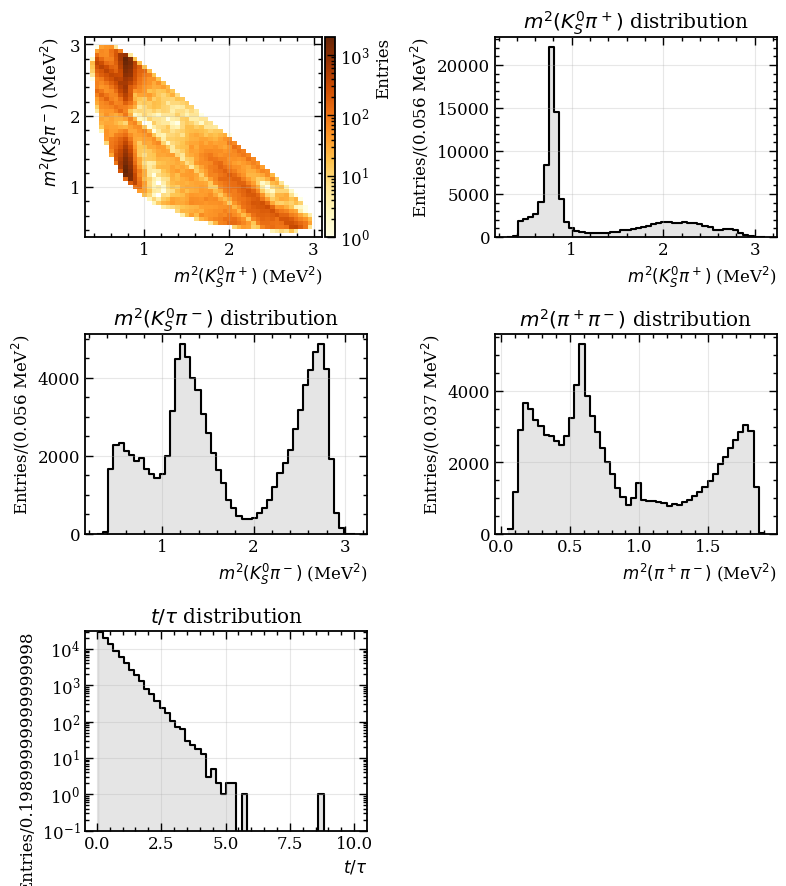

In [14]:
fig, ax= plot_data_mix(toy_sample, c_phsp)

  Updating maximum: 1e-20 -> 6914.245671190688. Starting over.
  Chunk 1, size=5309, total length=5309
  Chunk 2, size=5447, total length=10756
  Chunk 3, size=5413, total length=16169
  Chunk 4, size=5272, total length=21441
  Chunk 5, size=5319, total length=26760
  Chunk 6, size=5437, total length=32197
  Chunk 7, size=5346, total length=37543
  Chunk 8, size=5294, total length=42837
  Chunk 9, size=5316, total length=48153
  Chunk 10, size=5235, total length=53388
  Chunk 11, size=5458, total length=58846
  Chunk 12, size=5404, total length=64250
  Chunk 13, size=5468, total length=69718
  Chunk 14, size=5407, total length=75125
  Chunk 15, size=5340, total length=80465
  Chunk 16, size=5511, total length=85976
  Chunk 17, size=5260, total length=91236
  Chunk 18, size=5273, total length=96509
  Chunk 19, size=5184, total length=101693


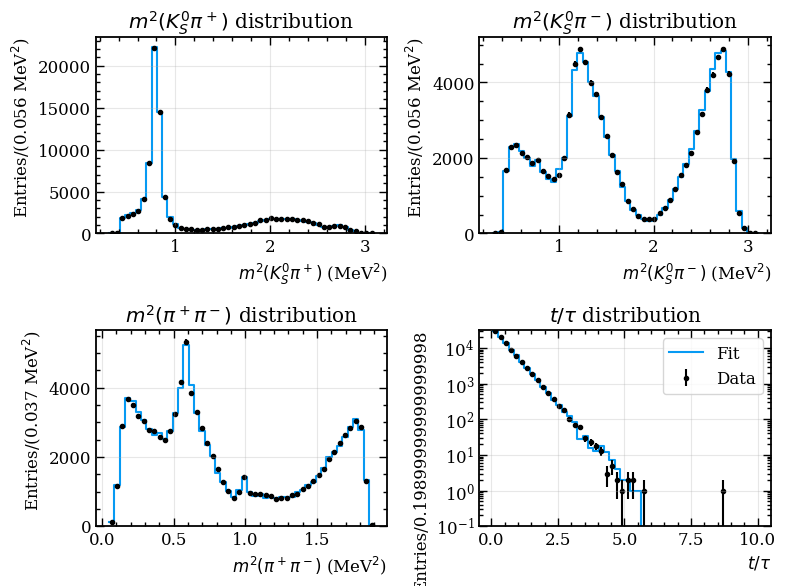

In [46]:
x_mix = atfi.const(0.004)
y_mix = atfi.const(0.0064)
qoverp = atfi.complex(atfi.const(1.0), atfi.const(0.0))
def toymc_model_mix(x):
    return model_mix(x)(
        x_mix_par=x_mix,
        y_mix_par=y_mix,
        qoverp_re=atfi.real(qoverp),
        qoverp_im=atfi.imaginary(qoverp)
        )
toy_sample_mix = tft.run_toymc(
    toymc_model_mix, c_phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)
fig, ax = plot_data_comparison_mix([toy_sample,toy_sample_mix], c_phsp)

In [ ]:
x_mix = atfi.const(0.2)
y_mix = atfi.const(0.2)
qoverp = atfi.complex(atfi.const(1.5), atfi.const(0.0))
def toymc_model_mix(x):
    return model_mix(x)(
        x_mix_par=x_mix,
        y_mix_par=y_mix,
        qoverp_re=atfi.real(qoverp),
        qoverp_im=atfi.imaginary(qoverp)
        )
toy_sample_mix = tft.run_toymc(
    toymc_model_mix, c_phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)
fig, ax = plot_data_comparison_mix([toy_sample,toy_sample_mix], c_phsp)

  Updating maximum: 1e-20 -> 6492.553850651866. Starting over.
  Chunk 1, size=6015, total length=6015
  Chunk 2, size=5949, total length=11964
  Chunk 3, size=6023, total length=17987
  Chunk 4, size=5975, total length=23962
  Chunk 5, size=5933, total length=29895
  Chunk 6, size=5785, total length=35680
  Chunk 7, size=5915, total length=41595
  Chunk 8, size=5929, total length=47524
  Chunk 9, size=5954, total length=53478
  Chunk 10, size=5960, total length=59438
  Chunk 11, size=6058, total length=65496
  Chunk 12, size=5957, total length=71453
  Chunk 13, size=6029, total length=77482
  Chunk 14, size=5990, total length=83472
  Chunk 15, size=5931, total length=89403
  Chunk 16, size=6101, total length=95504
  Chunk 17, size=6093, total length=101597


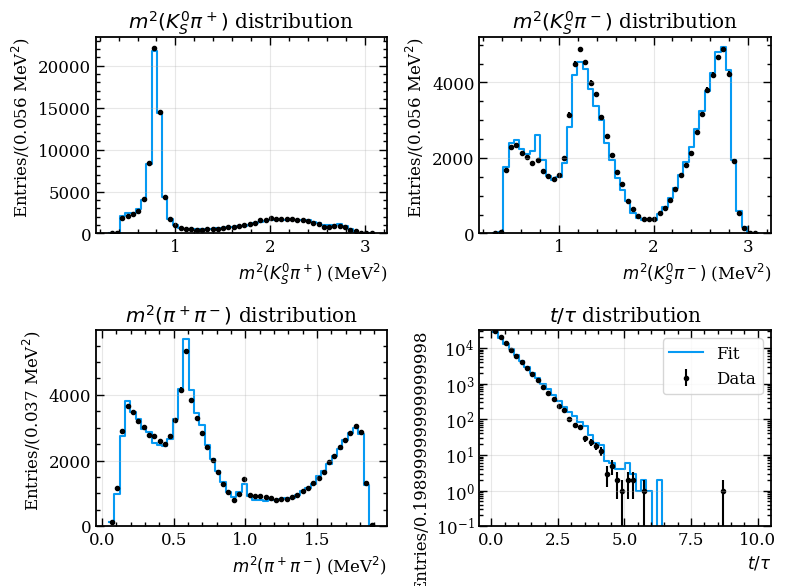

In [44]:
fig, ax = plot_data_comparison_mix([toy_sample,toy_sample_mix], c_phsp)

Effects of mixing and CPV become visible when large mixing parameters are used.

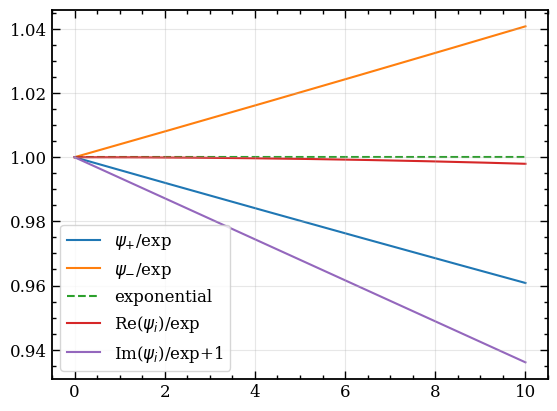

In [47]:
x_mix = atfi.const(0.004)
y_mix = atfi.const(0.0064)
t_pl = np.linspace(0,10,1000)
plt.plot( t_pl, atfm.psip(t_pl, x_mix, tdz)/np.exp(-t_pl/tdz), label=r'$\psi_{+}$/exp' )
plt.plot( t_pl, atfm.psim(t_pl, x_mix, tdz)/np.exp(-t_pl/tdz), label=r'$\psi_{-}$/exp' )
plt.plot( t_pl, np.ones(len(t_pl)), label='exponential', linestyle='dashed' )
plt.plot( t_pl, np.real(atfm.psii(t_pl, y_mix, tdz))/np.exp(-t_pl/tdz), label=r'Re($\psi_{i}$)/exp' )
plt.plot( t_pl, 1+np.imag(atfm.psii(t_pl, y_mix, tdz))/np.exp(-t_pl/tdz), label=r'Im($\psi_{i}$)/exp+1' )
#plt.yscale('log')
plt.legend()

## Likelihood

The Negative Log Likelihood

In [54]:
# TF graph for unbinned negalite log likelihood (the quantity to be minimised)
def nll(data, norm):
    data_model = model_mix(data)
    norm_model = model_mix(norm)

    @atfi.function
    def _nll(pars):
        return atfl.unbinned_nll(data_model(**pars), atfl.integral(norm_model(**pars)))

    return _nll

## Samples

The samples to fit

In [ ]:
ntoys = 5000000
nnorm = 10*ntoys

In [75]:
x_mix = atfi.const(0.004)
y_mix = atfi.const(0.0064)
qoverp = atfi.complex(atfi.const(1.0), atfi.const(0.0))
def toymc_model_mix(x):
    return model_mix(x)(
        x_mix_par=x_mix,
        y_mix_par=y_mix,
        qoverp_re=atfi.real(qoverp),
        qoverp_im=atfi.imaginary(qoverp)
        )
toy_sample_mix = tft.run_toymc(
    toymc_model_mix, c_phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)
print(toy_sample_mix)

  Updating maximum: 1e-20 -> 6813.855822230631. Starting over.
  Chunk 1, size=5446, total length=5446
  Chunk 2, size=5378, total length=10824
  Chunk 3, size=5421, total length=16245
  Chunk 4, size=5480, total length=21725
  Chunk 5, size=5295, total length=27020
  Chunk 6, size=5453, total length=32473
  Chunk 7, size=5470, total length=37943
  Chunk 8, size=5482, total length=43425
  Chunk 9, size=5594, total length=49019
  Chunk 10, size=5503, total length=54522
  Chunk 11, size=5388, total length=59910
  Chunk 12, size=5303, total length=65213
  Chunk 13, size=5405, total length=70618
  Chunk 14, size=5408, total length=76026
  Chunk 15, size=5342, total length=81368
  Chunk 16, size=5449, total length=86817
  Chunk 17, size=5556, total length=92373
  Chunk 18, size=5493, total length=97866
  Chunk 19, size=5450, total length=103316
  Chunk 20, size=5467, total length=108783
  Chunk 21, size=5411, total length=114194
  Chunk 22, size=5432, total length=119626
  Chunk 23, size=53

and to calculate the integrals

In [76]:
norm_sample = c_phsp.uniform_sample(nnorm)
print(norm_sample)

tf.Tensor(
[[1.39821078 1.43301426 0.05434906]
 [2.50695273 1.15903186 1.40617314]
 [1.53831332 1.19657883 0.70795715]
 ...
 [1.50718507 0.69072219 0.08931615]
 [1.84779898 0.84255299 1.21623305]
 [0.93839681 1.05244998 1.71522414]], shape=(47476108, 3), dtype=float64)


Beware that only approximately 1/2 of the events have been generated in the normalisation sample.

## Fit

We are now ready to run the fit. We define first the fit parameters:

In [77]:
pars = [
    tfo.FitParameter("x_mix_par", 0.004, -0.02, 0.02),
    tfo.FitParameter("y_mix_par", 0.006, -0.02, 0.02),
    tfo.FitParameter("qoverp_re", 1.0, -1.5, 1.5),
    tfo.FitParameter("qoverp_im", 0.0, -1.5, 1.5),
]
fixed_pars = ['qoverp_re','qoverp_im']
for p in pars:
    if p.name in fixed_pars:
        p.fix()

In [78]:
for p in pars:
    print(p.name, p.floating())

x_mix_par True
y_mix_par True
qoverp_re False
qoverp_im False


and run Minuit

In [79]:
# Run MINUIT minimisation of the neg. log likelihood
result = tfo.run_minuit(nll(toy_sample_mix, norm_sample), pars)
print(result)
cov = result['covariance'] if 'covariance' in result.keys() else None
if cov is None: print('COVARIANCE NOT VALID')

print(f"{result['time']/result['func_calls']} sec per function call")

fitted_pars = {p: atfi.const(v[0]) for p, v in result["params"].items()}

2025-06-05 15:53:27.377436: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.54GiB (rounded to 3798088704)requested by op PartitionedCall_2/PartitionedCall/Cast_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-06-05 15:53:27.377487: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-06-05 15:53:27.377499: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 244, Chunks in use: 243. 61.0KiB allocated for chunks. 60.8KiB in use in bin. 2.5KiB client-requested in use in bin.
2025-06-05 15:53:27.377509: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 800B client-req

ResourceExhaustedError: Graph execution error:

Detected at node Cast_1 defined at (most recent call last):
  File "/usr/lib64/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/usr/lib64/python3.9/runpy.py", line 87, in _run_code

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib64/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/usr/lib64/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/usr/lib64/python3.9/asyncio/events.py", line 80, in _run

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_941233/1357853679.py", line 2, in <module>

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/tfa/toymc.py", line 96, in run_toymc

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/tfa/toymc.py", line 70, in pdf_vals

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/tfa/toymc.py", line 28, in accept_reject_sample

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/tfa/toymc.py", line 30, in accept_reject_sample

  File "/tmp/ipykernel_941233/1633730129.py", line 6, in toymc_model_mix

  File "/tmp/ipykernel_941233/1481103439.py", line 3, in model_mix

  File "/tmp/ipykernel_941233/4089901277.py", line 78, in Af

  File "/tmp/ipykernel_941233/4089901277.py", line 44, in babar_model_amp

  File "/user/gr1/lhcb/mmartinelli/dalitz/tfa_examples/models/d02kspipi.py", line 442, in babar2008_model_amp

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/amplitf/dynamics.py", line 1190, in kmatrix_lineshape

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/amplitf/dynamics.py", line 1096, in kmatrix_prodvec

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/amplitf/dynamics.py", line 1049, in resonant_kmatrix_prodvec

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/amplitf/interface.py", line 145, in cast_complex

Detected at node Cast_1 defined at (most recent call last):
  File "/usr/lib64/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/usr/lib64/python3.9/runpy.py", line 87, in _run_code

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib64/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/usr/lib64/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/usr/lib64/python3.9/asyncio/events.py", line 80, in _run

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_941233/1357853679.py", line 2, in <module>

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/tfa/toymc.py", line 96, in run_toymc

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/tfa/toymc.py", line 70, in pdf_vals

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/tfa/toymc.py", line 28, in accept_reject_sample

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/tfa/toymc.py", line 30, in accept_reject_sample

  File "/tmp/ipykernel_941233/1633730129.py", line 6, in toymc_model_mix

  File "/tmp/ipykernel_941233/1481103439.py", line 3, in model_mix

  File "/tmp/ipykernel_941233/4089901277.py", line 78, in Af

  File "/tmp/ipykernel_941233/4089901277.py", line 44, in babar_model_amp

  File "/user/gr1/lhcb/mmartinelli/dalitz/tfa_examples/models/d02kspipi.py", line 442, in babar2008_model_amp

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/amplitf/dynamics.py", line 1190, in kmatrix_lineshape

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/amplitf/dynamics.py", line 1096, in kmatrix_prodvec

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/amplitf/dynamics.py", line 1049, in resonant_kmatrix_prodvec

  File "/user/gr1/lhcb/mmartinelli/environments/tfa/lib64/python3.9/site-packages/amplitf/interface.py", line 145, in cast_complex

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  failed to allocate memory
	 [[{{node Cast_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[PartitionedCall_1/PartitionedCall/Cast/_2]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  failed to allocate memory
	 [[{{node Cast_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_kmatrix_lineshape_1786]

Define a function with the fitted model to calculate fit fractions and projections

In [ ]:
def fitted_model(x):
    return model_mix(x)(**fitted_pars)

## Plotting

For plotting the results we generate a sample according to the model and we overlay it to the data

In [ ]:
fitted_sample = tft.run_toymc(
    fitted_model, c_phsp, nnorm, maximum=1.0e-20, chunk=1000000, components=True
)

  Updating maximum: 1e-20 -> 6538.435961322653. Starting over.
  Chunk 1, size=5772, total length=5772
  Chunk 2, size=5633, total length=11405
  Chunk 3, size=5651, total length=17056
  Chunk 4, size=5724, total length=22780
  Chunk 5, size=5596, total length=28376
  Chunk 6, size=5679, total length=34055
  Chunk 7, size=5654, total length=39709
  Chunk 8, size=5774, total length=45483
  Chunk 9, size=5631, total length=51114
  Chunk 10, size=5636, total length=56750
  Chunk 11, size=5703, total length=62453
  Chunk 12, size=5651, total length=68104
  Chunk 13, size=5692, total length=73796
  Chunk 14, size=5830, total length=79626
  Chunk 15, size=5724, total length=85350
  Chunk 16, size=5692, total length=91042
  Chunk 17, size=5753, total length=96795
  Chunk 18, size=5599, total length=102394
  Chunk 19, size=5688, total length=108082
  Chunk 20, size=5732, total length=113814
  Chunk 21, size=5831, total length=119645
  Chunk 22, size=5752, total length=125397
  Chunk 23, size=5

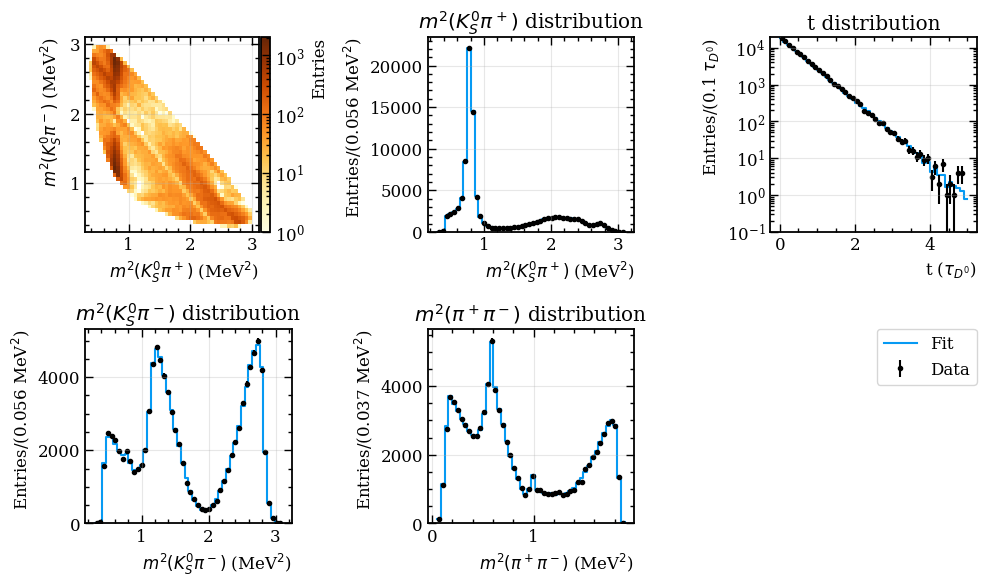

In [ ]:
# Plot results
import matplotlib.pyplot as plt

tfp.set_lhcb_style(size=12, usetex=False)  # Adjust plotting style for LHCb papers
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))  # Single subplot on the figure

# Plot 1D histogram from the toy MC sample
tfp.plot_distr2d(
    toy_sample_mix[:, 0],
    toy_sample_mix[:, 1],
    bins=(50, 50),
    ranges=((0.3, 3.1), (0.3, 3.1)),
    fig=fig,
    ax=ax[0, 0],
    labels=(r"$m^2(K_S^0\pi^+)$", r"$m^2(K_S^0\pi^-)$"),
    units=("MeV$^2$", "MeV$^2$"),
    log=True,
)

tfp.plot_distr1d_comparison(
    toy_sample_mix[:, 0],
    fitted_sample[:, 0],
    #cweights=[fitted_sample[:, 3 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[0, 1],
    label=r"$m^2(K_S^0\pi^+)$",
    units="MeV$^2$",
    legend=False
)

tfp.plot_distr1d_comparison(
    toy_sample_mix[:, 1],
    fitted_sample[:, 1],
    #cweights=[fitted_sample[:, 3 + i] for i in range(4)],
    bins=50,
    range=(0.3, 3.1),
    ax=ax[1, 0],
    label=r"$m^2(K_S^0\pi^-)$",
    units="MeV$^2$",
    legend=False
)

tfp.plot_distr1d_comparison(
    toy_sample_mix[:, 2],
    fitted_sample[:, 2],
    #cweights=[fitted_sample[:, 3 + i] for i in range(4)],
    bins=50,
    range=(0., 5),
    ax=ax[0, 2],
    label=r"t",
    units=r"$\tau_{D^0}$",
    log=True,
    legend=False
)

tfp.plot_distr1d_comparison(
    c_phsp.phsp1.m2ac(c_phsp.data1(toy_sample_mix)),
    c_phsp.phsp1.m2ac(c_phsp.data1(fitted_sample)),
    #cweights=[fitted_sample[:, 3 + i] for i in range(4)],
    bins=50,
    range=(0.05, 1.9),
    ax=ax[1, 1],
    label=r"$m^2(\pi^+\pi^-)$",
    units="MeV$^2$",
    legend_ax=ax[1,2]
)

# Show the plot
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)